In [6]:
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from scipy.interpolate import RegularGridInterpolator
from FD_functions.functions_3d import pizzo_maccormack, upwind, flux_limiter_upwinds, f_function
import numpy as np
from FD_functions.interpolation import interpolate_initial_condition
from astropy.constants import m_p
import rom_operator_inference as roi
import astropy.units as u
import matplotlib.pyplot as plt
from rom_tools import flatten, undo_flatten, normalize_min_max, qDEIM
import scipy.linalg as la
import matplotlib
import scipy.signal

font = {'family': 'serif',
        'size': 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

In [7]:
# FOM solution saved.
FOM_SOL = np.load('data/data.npy')
quantities, n_phi, n_theta, n_radial = np.shape(FOM_SOL)
n_theta

200

In [8]:
p = np.linspace(0, 2*np.pi, n_phi)
t = np.linspace(0, np.pi, n_theta)
r = (np.linspace(0.14, 1.1, n_radial) * u.AU).to(u.km)

In [9]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)


def shift_vector_fun(data, n_radial, p):
    # initial condition
    v1 = data[:, :, 0]
    shift_vec = [0]
    
    for ii in range(1, n_radial):
        v2 = data[:, :, ii]
        corr = periodic_corr_2d(normalize(v1), normalize(v2))
        shift_vec.append(p[np.argmax(corr)]*180/np.pi)
    return shift_vec

In [10]:
shift_vec_vr = shift_vector_fun(data=FOM_SOL[0, :, :, :], n_radial=n_radial, p=p)
shift_vec_rho = shift_vector_fun(data=FOM_SOL[1, :, :, :], n_radial=n_radial, p=p)
shift_vec_p = shift_vector_fun(data=FOM_SOL[2, :, :, :], n_radial=n_radial, p=p)
shift_vec_np = shift_vector_fun(data=FOM_SOL[3, :, :, :], n_radial=n_radial, p=p)
shift_vec_nt = shift_vector_fun(data=FOM_SOL[4, :, :, :], n_radial=n_radial, p=p)

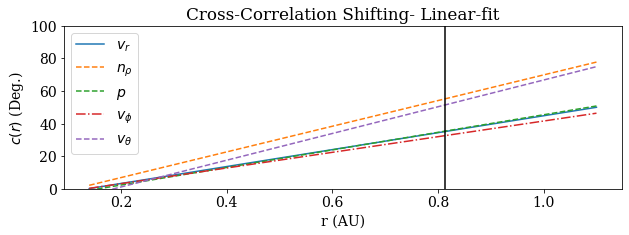

In [11]:
fig, ax = plt.subplots(figsize =(10, 3))

m_vec = np.zeros(5)
b_vec = np.zeros(5)

n = int(len(r)*0.7)
#ax.scatter(r.to(u.AU), shift_vec_vr, s=5)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec_vr[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, "-", label=r"$v_{r}$")
m_vec[0] = m
b_vec[0] = b


#ax.scatter(r.to(u.AU), shift_vec_rho, s=5, )
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec_rho[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b,"--", label=r"$n_{\rho}$")
m_vec[1] = m
b_vec[1] = b


#ax.scatter(r.to(u.AU), shift_vec_p, s=5)
m, b = np.polyfit(r[40:n].to(u.AU).value, shift_vec_p[40:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, "--", label=r"$p$")
m_vec[2] = m
b_vec[2] = b

#ax.scatter(r.to(u.AU), shift_vec_np, s=5)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec_np[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, "-.",  label=r"$v_{\phi}$")
m_vec[3] = m
b_vec[3] = b

#ax.scatter(r.to(u.AU), shift_vec_nt, s=5)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec_nt[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b,  "--", label=r"$v_{\theta}$")
m_vec[4] = m
b_vec[4] = b

_ = ax.axvline(r[n].to(u.AU).value, c="k")

ax.set_ylim(0, 100)
plt.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting- Linear-fit")

# Save all quantities on shifted coordinates. 

In [77]:
(m_vec[2]*np.pi/180)*(1/u.AU).to(1/u.km)

<Quantity 6.28609801e-09 1 / km>

In [56]:
def plot_slices_fig(data, title="MHD CR2210", figsave="figs/mhd_2D_slices.png"):
    fig = plt.figure(figsize=(10,12))
    for id_subplot, snapshot in enumerate(np.append(np.arange(0, len(r), 100), len(r)-1), start=1):
        plt.subplot(4, 2, id_subplot)
        im = plt.imshow(data[:, :, snapshot].T,
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[-1]*180/np.pi, t[0]*180/np.pi],   
                     cmap="plasma", aspect="auto")
        plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.xticks([360, 270, 180, 90, 0])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.3, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle(title)
    plt.tight_layout()

    #fig.savefig(figsave, dpi=300, bbox_inches='tight')

In [57]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [58]:
def shift_function(r, m, b):
    return m * r + b

In [59]:
def get_shifted_data(data, n_radial, p, t, m, b):
    data_new = np.zeros(data.shape)

    # initial conditon. 
    data_new[:, :, 0] = data[:, :, 0]

    for jj in range(1, n_radial):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi - shift) % (360)
        # interpolate over the shifted coordinate
        data_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=data[:, :, jj]).T
    return data_new

In [60]:
NEW_FOM_SOL = np.zeros(FOM_SOL.shape)

m = np.mean(m_vec)
b = np.mean(b_vec)

NEW_FOM_SOL[0, :, :, :] = get_shifted_data(FOM_SOL[0, :, :, :], n_radial=n_radial, p=p, t=t, m=m, b=b)
NEW_FOM_SOL[1, :, :, :] = get_shifted_data(FOM_SOL[1, :, :, :], n_radial=n_radial, p=p, t=t, m=m, b=b)
NEW_FOM_SOL[2, :, :, :] = get_shifted_data(FOM_SOL[2, :, :, :], n_radial=n_radial, p=p, t=t, m=m, b=b)
NEW_FOM_SOL[3, :, :, :] = get_shifted_data(FOM_SOL[3, :, :, :], n_radial=n_radial, p=p, t=t, m=m, b=b)
NEW_FOM_SOL[4, :, :, :] = get_shifted_data(FOM_SOL[4, :, :, :], n_radial=n_radial, p=p, t=t, m=m, b=b)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_32489/1208554155.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


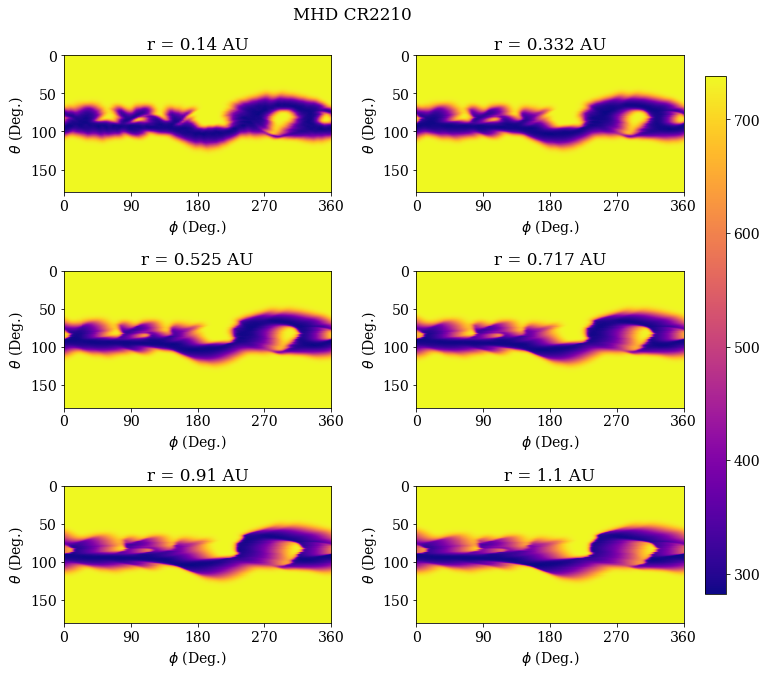

In [61]:
plot_slices_fig(data=NEW_FOM_SOL[0, :, :, :], title="MHD CR2210", figsave=False)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_32489/1208554155.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


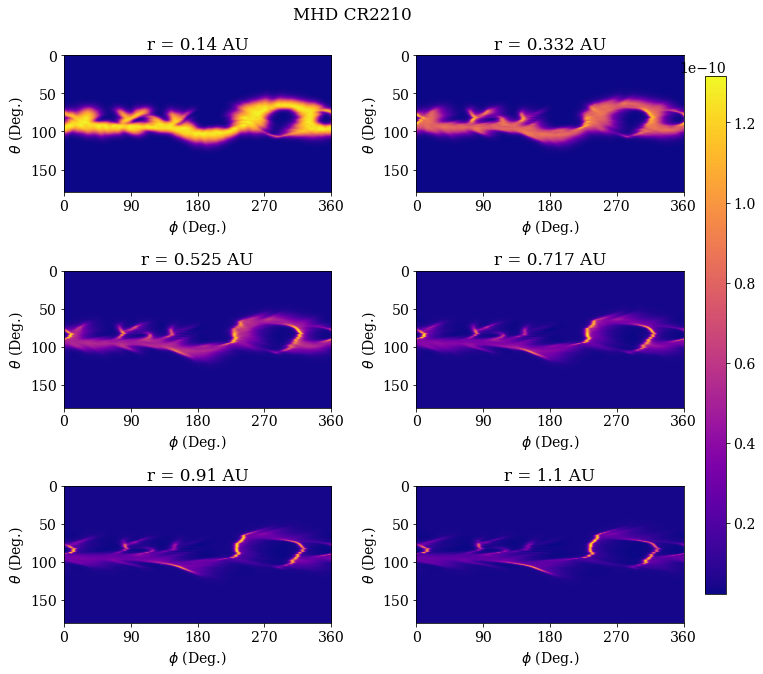

In [62]:
plot_slices_fig(data=NEW_FOM_SOL[1, :, :, :], title="MHD CR2210", figsave=False)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_32489/1208554155.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


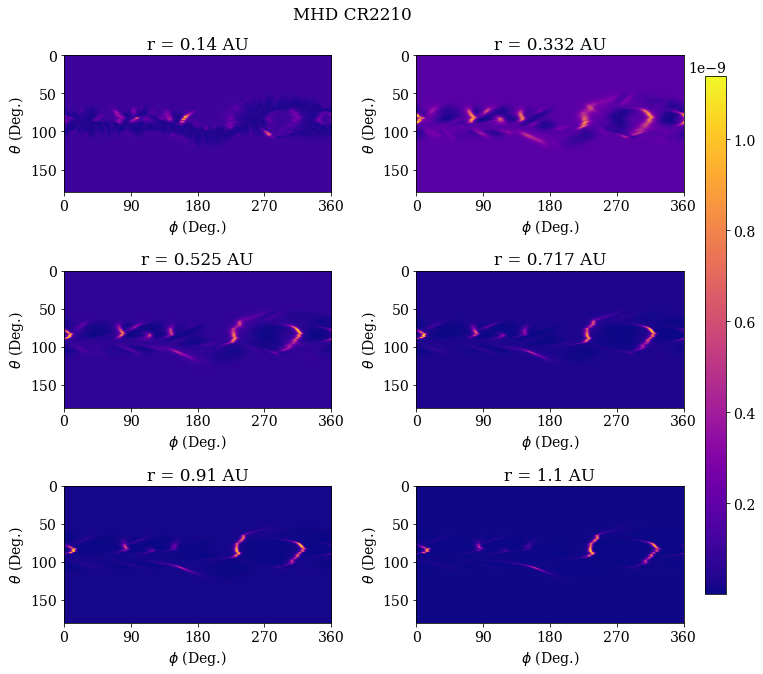

In [63]:
plot_slices_fig(data=NEW_FOM_SOL[2, :, :, :], title="MHD CR2210", figsave=False)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_32489/1208554155.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


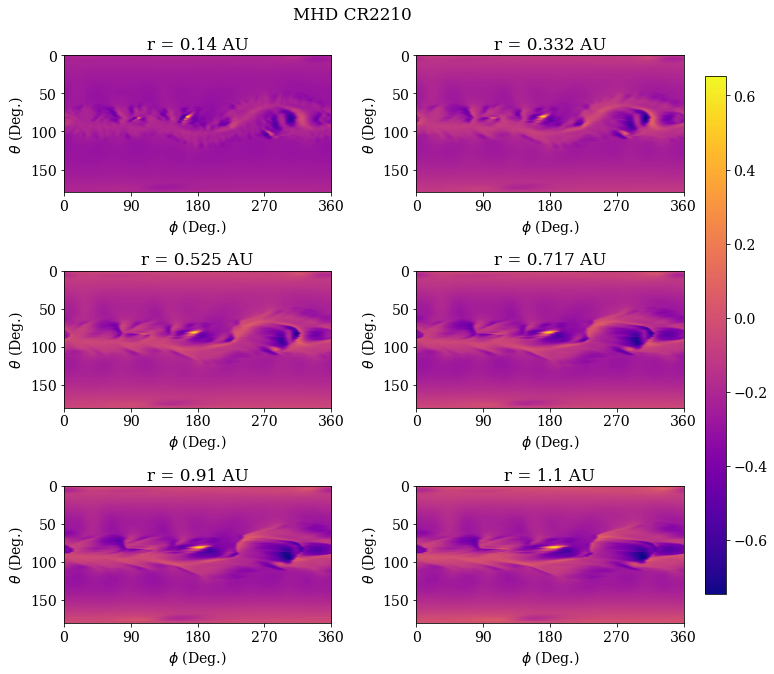

In [64]:
plot_slices_fig(data=NEW_FOM_SOL[3, :, :, :], title="MHD CR2210", figsave=False)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_32489/1208554155.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


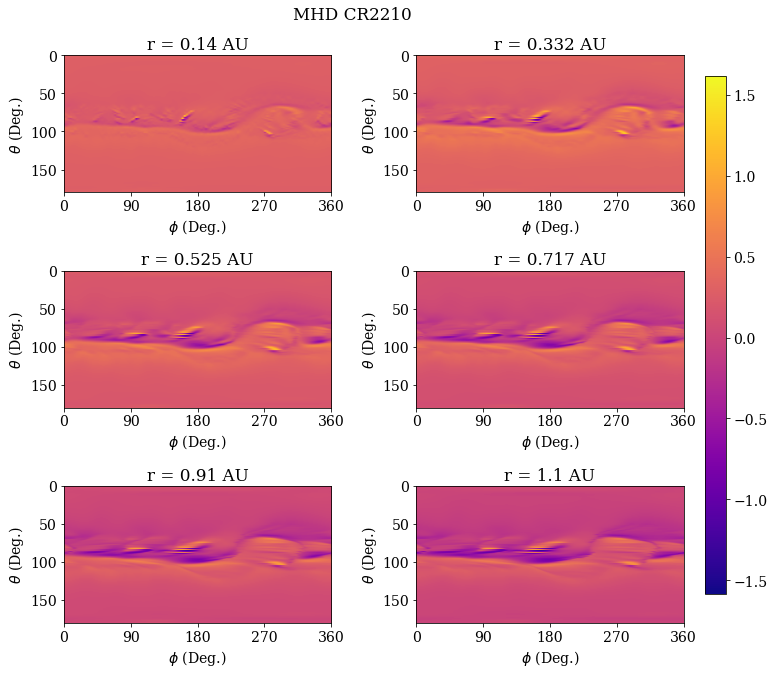

In [65]:
plot_slices_fig(data=NEW_FOM_SOL[4, :, :, :], title="MHD CR2210", figsave=False)

In [66]:
# Saving the array in a text file
np.save("data_shifted.npy", NEW_FOM_SOL)

In [67]:
m_vec_correct_units = (m_vec * (np.pi/180)*(1/u.AU)).to(1/u.km).value
b_vec_correct_units = (b_vec * (np.pi/180))

In [68]:
np.save("data/m.npy", np.mean(m_vec_correct_units))
np.save("data/b.npy", np.mean(b_vec_correct_units))

In [69]:
np.mean(m_vec_correct_units)

7.338719759882489e-09

In [70]:
 np.mean(b_vec_correct_units)

-0.16136757187924122

In [72]:
(2*np.pi/(25.38*3600))/600


1.1461316338286902e-07